# How to Build an Emotional Tone Analyzer from Scratch

## How to build a high-performance emotional tone analyzer to compete with IBM Watson  with no transaction charges

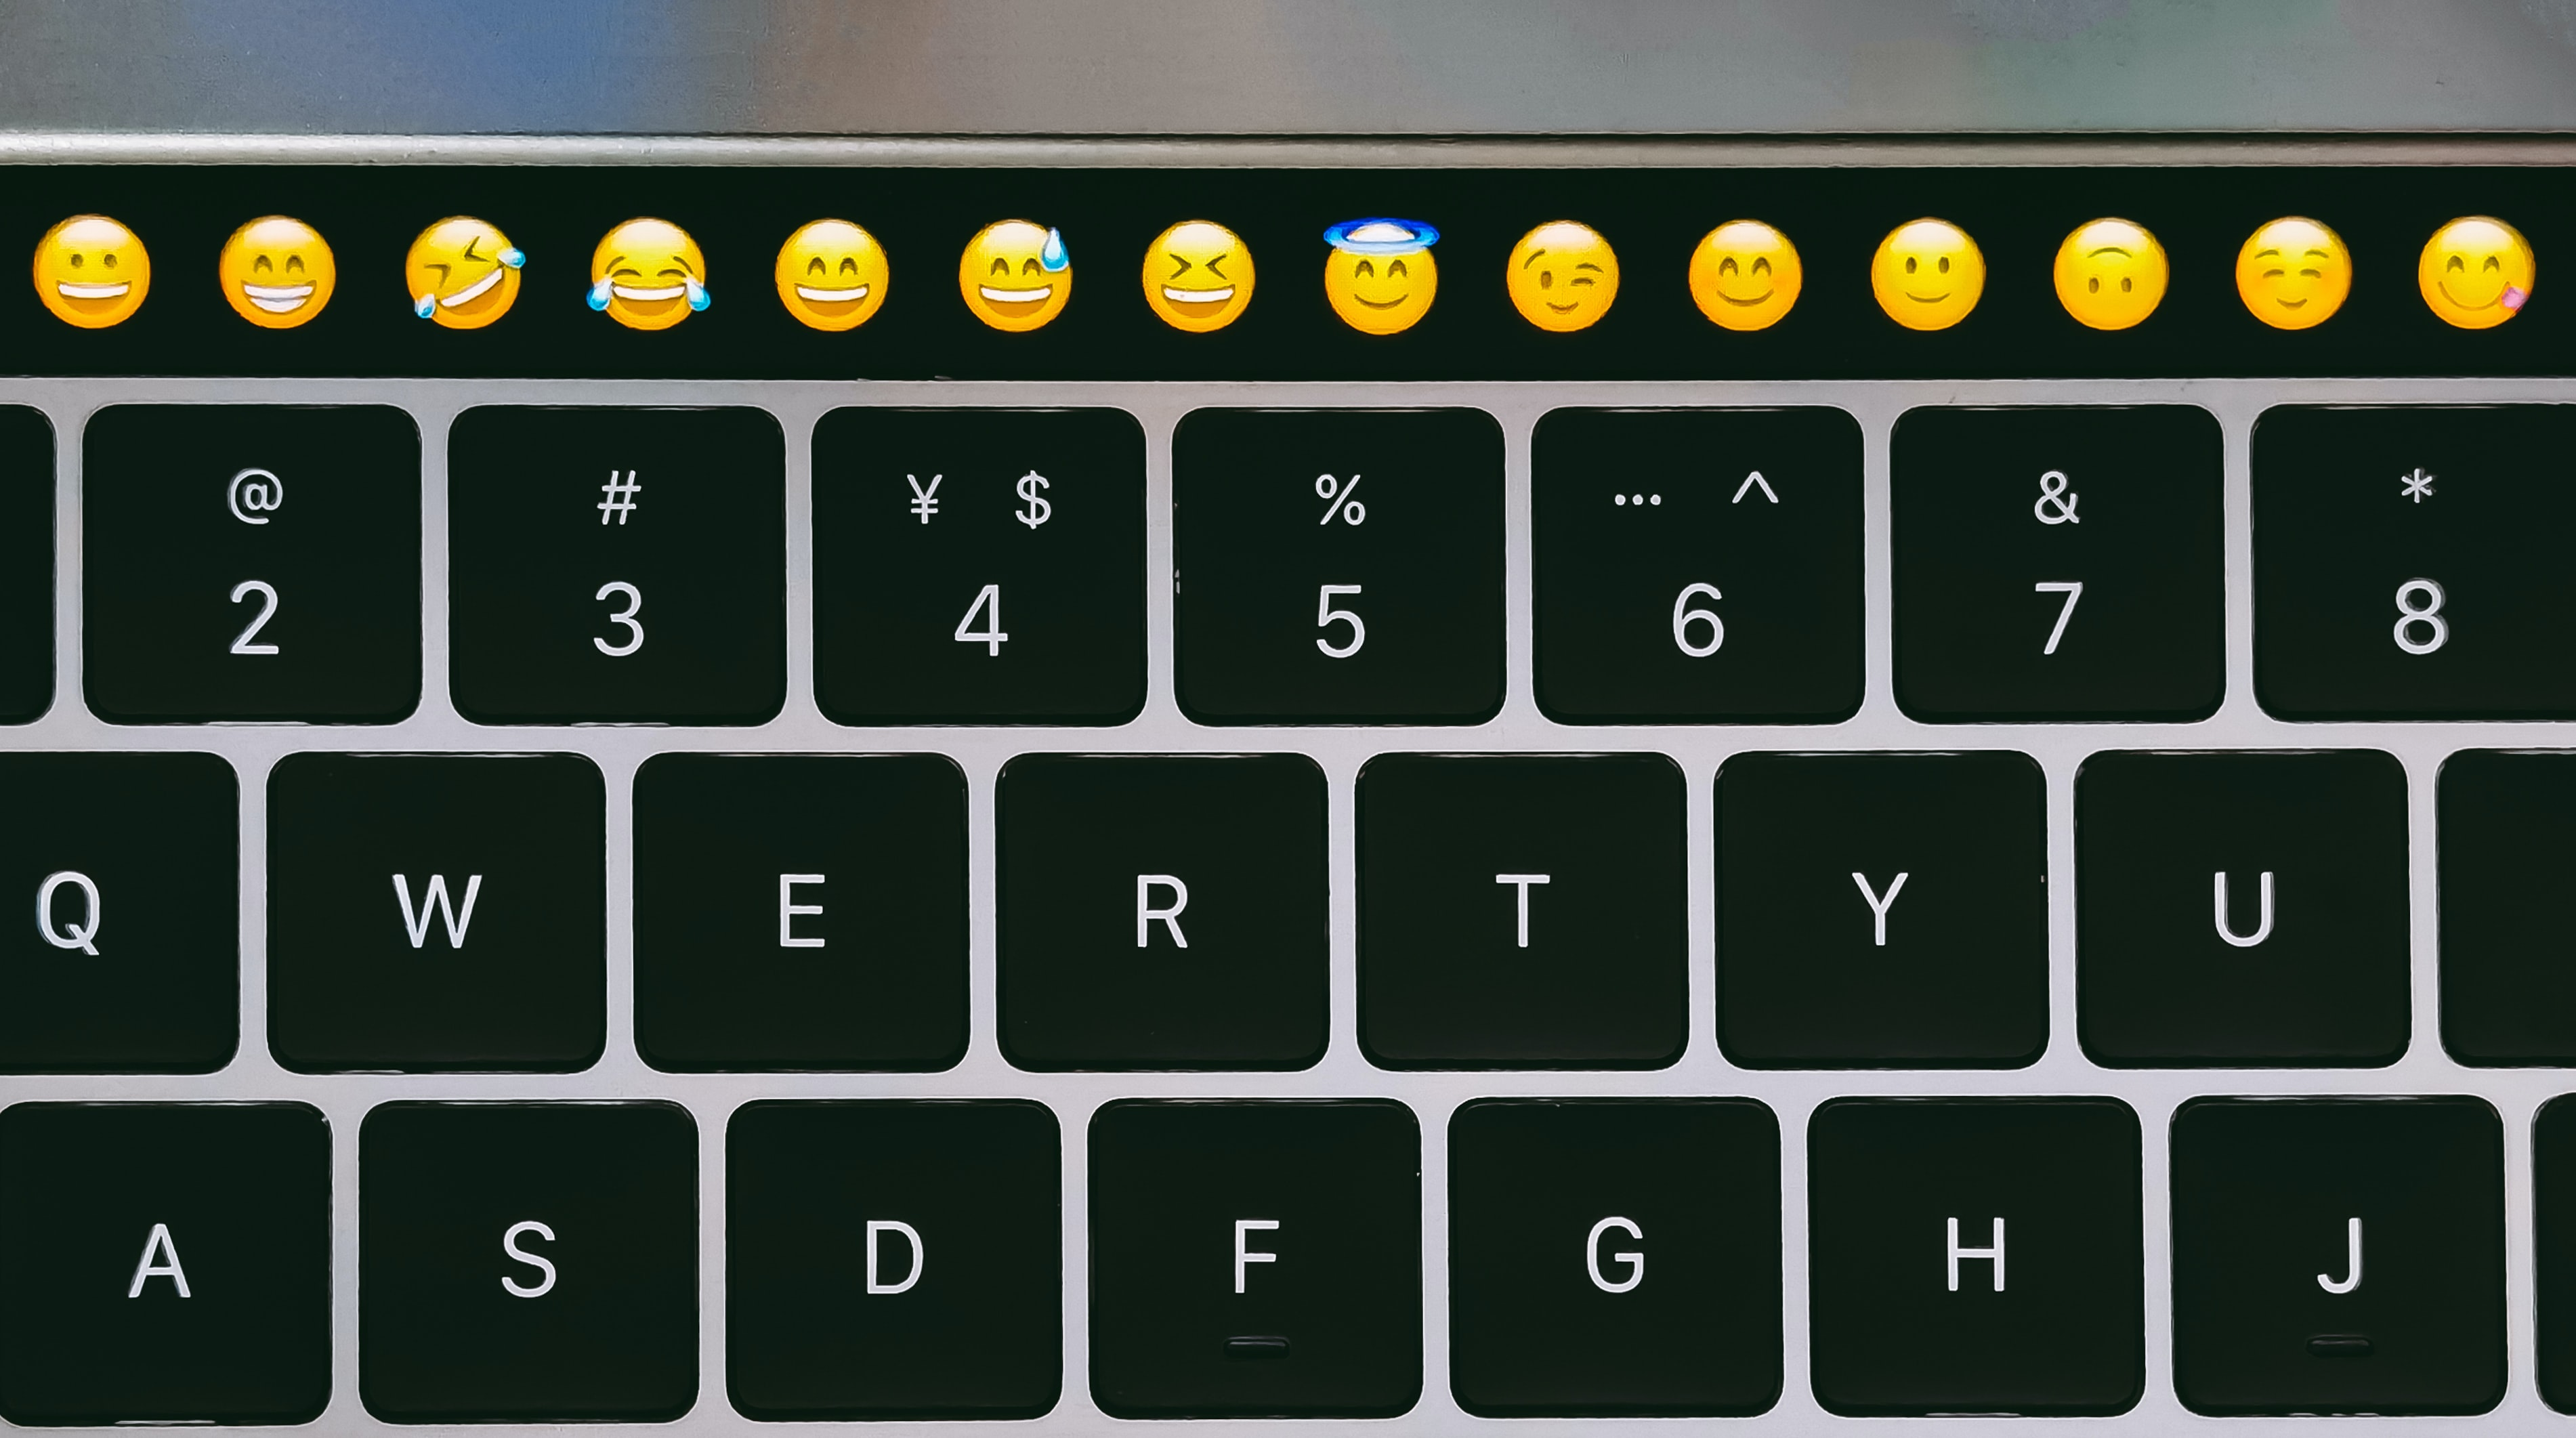
Photo by <a href="https://unsplash.com/@takeshi2?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">wu yi</a> on <a href="https://unsplash.com/s/photos/emoji?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Introduction
In a recent article I showed how to use the IBM Watson "Tone Analyzer" which enables the emotional analysis of text to be directly embedded into machine learning applications written in Python (or other languages).

The article went on to develop and explain Python code that explored an open-license dataset relating to customer feedback of a fictitious online women's clothing retailer using the tone analyzer to predict what emotion the customer was feeling when they wrote the review.

In the conclusion I noted that the free pricing plan for IBM Watson limits clients to 2,500 API calls per month and that if I had chosen to execute the code against all 23,000 data points their would have been a metered cost of $202 (~£149) and it would have taken about 4 hours for the code to run.

When I reflected on the pros and cons of the IBM Watson Tone Analyzer I began to wonder how I could write something similar myself that would make useful predictions about the emotions customers were feeling when they wrote free-text format feedback but that would perform much quicker and avoid the transaction costs for large datasets.

The rest of this article explains how I build my emotional tone analyzer from scratch and how it compared to the IBM Watson service.

See https://towardsdatascience.com/how-to-use-the-ibm-watson-tone-analyzer-to-perform-emotional-sentiment-analysis-in-python-d1d4ad022d0b for full details of the original article. 

### Building the Emotional Tone Analyzer

#### 1. Getting Some Data
The first thing to do is to get some data to build and test again and I have chosen to re-use the open license women's clothing online retail dataset (https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews).

This data is licensed under the "CC0: Public Domain" license which means that "you can copy, modify, distribute and perform the work, even for commercial purposes, all without asking permission" (see https://creativecommons.org/publicdomain/zero/1.0/) for details).

In [1]:
import pandas as pd

df_reviews = pd.read_excel(f"https://github.com/grahamharrison68/Public-Github/blob/master/Analyzing%20Customer%20Feedback/data/out/Womens%20Clothing%20E-Commerce%20Reviews%20with%20Emotions.xlsx?raw=true")
df_reviews_raw = df_reviews.copy(deep=True)

df_reviews.dropna(inplace=True) 
df_reviews.reset_index(drop=True, inplace=True)

df_reviews.head()

,index,Review Title,Review Text,Review Rating,Review Positive Feedback Count,Review Polarity,Review Sentiment,Review Subjectivity,Review Length,Review Word Count,...,Reviewer Age,Reviewer Age Category,Emotion,Emotion Score,Division,Department,Product ID,Product Name,Product Category,Recommended?
0,1,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,0,0.550000,Positive,0.250000,124,22,...,50,45-54,Joy,0.972142,General Petite,Bottoms,1049,Product 1049,Pants,1
1,2,Flattering shirt,This shirt is very flattering to all due to th...,5,6,0.512891,Positive,0.137500,192,36,...,47,45-54,Joy,0.844207,General,Tops,847,Product 847,Blouses,1
2,3,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,4,0.178750,Positive,0.066250,488,98,...,49,45-54,Joy,0.668897,General,Dresses,1080,Product 1080,Dresses,0
3,4,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,0.133750,Positive,0.215556,496,101,...,39,35-44,Joy,0.573683,General Petite,Tops,858,Product 858,Knits,1
4,5,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,4,0.171635,Positive,-0.007692,482,97,...,39,35-44,Joy,0.554208,General Petite,Tops,858,Product 858,Knits,1


The dataset I am using is the output dataset from the first article which had sampled 2000 rows and then used the free monthly quota of IBM Watson API calls to return the main emotion being experienced by the customer (``Emotion``) and a score indicating how strongly that emotion was (``Emotion Score``). 

I have also taken a copy of the dataset into ``df_reviews_raw`` for comparison purposes later on.

#### 2. Splitting into Training and Validation / Hold-out

In [4]:
from sklearn.model_selection import train_test_split

df_reviews_train, df_reviews_val = train_test_split(df_reviews, test_size=0.2, random_state=42)

df_reviews_train = df_reviews_train.copy(deep=True)
df_reviews_val = df_reviews_val.copy(deep=True)

df_reviews_train.reset_index(drop=True, inplace=True)
df_reviews_val.reset_index(drop=True, inplace=True)

Here I have chosen to sample two dataframes in an 80/20 ratio rather than take the more common approach of returning 4 numpy arrays (``X_train, y_train, X_test, y_test = train_test_split(df_reviews, test_size=0.2, random_state=42)``).

The reason is that later on I need to "vectorize" the review into a new set of features and it is much easier to do if the training and testing data is left as a DataFrame rather than a numpy array.

Finally the split dataframes have been deep copied to avoid the ``SetWithCopyWarning`` that would happen later on once we start adding new features to our sliced dataframes.

The training data will be used in a k-fold cross validation, effectively acting as both training and testing data whilst the validation / hold-out data will be used at the end of the modelling to judge performance and to avoid over-fitting.

#### 3. Rebalancing the Training Data

In [8]:
df_reviews_train['Emotion'].value_counts(normalize=True)

Joy        1264
Sadness     115
Anger        12
Fear         11
Name: Emotion, dtype: int64

The data is heavily imbalanced with the over 90% of data classified into the "Joy" emotion. During development I experimented with leaving the data imbalanced or rebalancing and rebalancing produces a model that performs much better against the hold-out dataset, so the data needs to be rebalanced ...

In [11]:
n = df_reviews_train.shape[0] // len(df_reviews_train['Emotion'].unique())
df_reviews_train = df_reviews_train.groupby("Emotion").sample(n=n, random_state=42, replace=True)
df_reviews_train.reset_index(drop=True, inplace=True)

This code resamples the data to provide a similar number of rows to the original dataframe but with an even sampling of the 4 emotions -

In [13]:
df_reviews_train['Emotion'].value_counts()

Anger      350
Fear       350
Joy        350
Sadness    350
Name: Emotion, dtype: int64

#### 4. Feature Engineering
The next stage is to use a ``TfidfVectorizer`` to vectorize the review text. This works by analyzing the text for unigrams (single words) and bigrams (combinations of two consecutive words) that correlate with the target variable. 

These ngrams can then be reviewed manaually to see if they make sense and then appended to the data to provide numerical features that can be used in a predictive machine learning classification algorithm,

In [ ]:
tfidf_vectorizer = TfidfVectorizer(encoding='utf-8', ngram_range=TFIDF_NGRAM_RANGE, stop_words=None, lowercase=False, max_df=TFIDF_MAX_DF, min_df=TFIDF_MIN_DF, max_features=TFIDF_MAX_FEATURES, norm='l2', sublinear_tf=True)
tfidf_features = tfidf_vectorizer.fit_transform(df_reviews_train['Review Text Wordcloud']).toarray()

https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb

https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training/06.%20MT%20-%20Random%20Forest.ipynb

https://towardsdatascience.com/text-classification-in-python-dd95d264c802

https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training



1. Read in the data
2. Test train split
3. use TFIFD to add in the new features
4. Use an algorithm to make some predictions
5. Assess the accuracy

In [1]:
DATA_IN_FOLDER : str = "../data/out/"
DATA_OUT_FOLDER : str = "../data/out/"

RANDOM_STATE : int = 42
    
SOURCE_TRAINING_DATA_FILE : str = "Womens Clothing E-Commerce Reviews with Emotions.xlsx"
SOURCE_FULL_DATA_FILE : str = "Womens Clothing E-Commerce Reviews.xlsx"
TARGET_FULL_DATA_FILE : str = "Womens Clothing E-Commerce Reviews with All Emotions.xlsx"
    
UTILITIES_PATH : str = r'C:\Users\GHarrison\OneDrive - Lincoln College\Python Projects\Data Science\Utilities'
MODEL_FILE : str = "ml_model.pkl"
VECTORIZER_FILE : str = "vectorizer.pkl"

RANDOM_STATE : int = 42

EMOTIONS : list = ['Joy', 'Sadness', 'Fear', 'Anger']
RESAMPLE : bool = True
    
TFIDF_NGRAM_RANGE : tuple = (1,2)
TFIDF_MAX_DF : float = 1.
TFIDF_MIN_DF : int = 10
TFIDF_MAX_FEATURES : int = 300
    
NUM_FOLDS : int = 5
SCORING :str = 'accuracy'
VERBOSE : int = 10
SEARCH_ITERATIONS = 500
    
RETUNE_HYPER_PARAMS : bool = False
USE_PRETUNED_HYPER_PARAMS : bool = True
TUNED_HYPER_PARAMS_50 : dict = {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
TUNED_HYPER_PARAMS_500 : dict = {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}    

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import copy as cp

from typing import Tuple
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import sys
sys.path.insert(1, UTILITIES_PATH)

from misc_tools import load_object, save_object

In [3]:
df_reviews = pd.read_excel(f"{DATA_IN_FOLDER}{SOURCE_TRAINING_DATA_FILE}")
df_reviews_raw = df_reviews.copy(deep=True)

df_reviews.dropna(inplace=True) 
df_reviews.reset_index(drop=True, inplace=True)

In [4]:
df_reviews.head()

,index,Review Title,Review Text,Review Rating,Review Positive Feedback Count,Review Polarity,Review Sentiment,Review Subjectivity,Review Length,Review Word Count,...,Reviewer Age,Reviewer Age Category,Emotion,Emotion Score,Division,Department,Product ID,Product Name,Product Category,Recommended?
0,1,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,0,0.550000,Positive,0.250000,124,22,...,50,45-54,Joy,0.972142,General Petite,Bottoms,1049,Product 1049,Pants,1
1,2,Flattering shirt,This shirt is very flattering to all due to th...,5,6,0.512891,Positive,0.137500,192,36,...,47,45-54,Joy,0.844207,General,Tops,847,Product 847,Blouses,1
2,3,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,4,0.178750,Positive,0.066250,488,98,...,49,45-54,Joy,0.668897,General,Dresses,1080,Product 1080,Dresses,0
3,4,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,0.133750,Positive,0.215556,496,101,...,39,35-44,Joy,0.573683,General Petite,Tops,858,Product 858,Knits,1
4,5,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,4,0.171635,Positive,-0.007692,482,97,...,39,35-44,Joy,0.554208,General Petite,Tops,858,Product 858,Knits,1


In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753 entries, 0 to 1752
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           1753 non-null   int64  
 1   Review Title                    1753 non-null   object 
 2   Review Text                     1753 non-null   object 
 3   Review Rating                   1753 non-null   int64  
 4   Review Positive Feedback Count  1753 non-null   int64  
 5   Review Polarity                 1753 non-null   float64
 6   Review Sentiment                1753 non-null   object 
 7   Review Subjectivity             1753 non-null   float64
 8   Review Length                   1753 non-null   int64  
 9   Review Word Count               1753 non-null   int64  
 10  Review Text Cleaned             1753 non-null   object 
 11  Review Text Wordcloud           1753 non-null   object 
 12  Reviewer Age                    17

In [6]:
df_reviews_train, df_reviews_val = train_test_split(df_reviews, test_size=0.2, random_state=RANDOM_STATE)

df_reviews_train.reset_index(drop=True, inplace=True)
df_reviews_val.reset_index(drop=True, inplace=True)

df_reviews_train = df_reviews_train.copy(deep=True)
df_reviews_val = df_reviews_val.copy(deep=True)

In [7]:
# Upsample the reviews
if RESAMPLE == True:
    n = df_reviews_train.shape[0] // len(df_reviews_train['Emotion'].unique())
    df_reviews_train = df_reviews_train.groupby("Emotion").sample(n=n, random_state=RANDOM_STATE, replace=True)
    df_reviews_train.reset_index(drop=True, inplace=True)    

In [8]:
df_reviews_train['Emotion'].value_counts()

Anger      350
Fear       350
Joy        350
Sadness    350
Name: Emotion, dtype: int64

In [9]:
tfidf_vectorizer = TfidfVectorizer(encoding='utf-8', ngram_range=TFIDF_NGRAM_RANGE, stop_words=None, lowercase=False, max_df=TFIDF_MAX_DF, min_df=TFIDF_MIN_DF, max_features=TFIDF_MAX_FEATURES, norm='l2', sublinear_tf=True)
tfidf_features = tfidf_vectorizer.fit_transform(df_reviews_train['Review Text Wordcloud']).toarray()

In [10]:
def get_correlated_ngrams(emotion_code : int, y : pd.Series):

    features_chi2 = chi2(tfidf_features, y == emotion_code) # For the current emotion, use chi2 stats to evaluate the highest correlations with the target
    indices = np.argsort(features_chi2[0])[::-1] # np.argsort returns the indices that would sort the array ascending, [::-1] makes it descending with the highest correlation in first place
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices] # get_feature_names uses the sorted indices to order the features most to least correlated with the target
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1] # Selects the feature names that are single words
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2] # Selects the feature names that are two words
    
    return unigrams, bigrams

In [11]:
#for emotion, emotion_code in sorted(emotion_map.items()):
for emotion in EMOTIONS:
    #unigrams, bigrams = get_correlated_ngrams(emotion_code, y_train)
    unigrams, bigrams = get_correlated_ngrams(emotion, df_reviews_train['Emotion'])
    
    print(f"{emotion}:")
    print(f"Most correleated unigrams: {', '.join(unigrams[:20])}")
    print(f"Most correleated bigrams: {', '.join(bigrams[:5])}\n")

Joy:
Most correleated unigrams: fits, great, comfortable, got, true, nice, pounds, love, perfect, bad, length, lay, petite, much, disappointed, across, pulled, though, bust, skirt
Most correleated bigrams: true size, runs slightly, need wear, dry clean, fabric bad

Sadness:
Most correleated unigrams: wanted, sad, disappointed, get, saw, like, pounds, great, wore, love, lay, size, even, much, material, received, first, would, across, still
Most correleated bigrams: need wear, runs slightly, going back, fabric bad, pounds usually

Fear:
Most correleated unigrams: across, pulled, shoulders, fear, squareapple, underlayer, types, si, narrow, done, space, slightly, romper, different, way, vest, chest, part, glad, guess
Most correleated bigrams: runs slightly, types fabric, small athletic, little short, space arms

Anger:
Most correleated unigrams: problem, strike, flat, pounds, idea, dressy, purchased, deep, zipper, mentioned, small, shows, appears, reviewers, lay, sheer, reviews, pants, cam

Now with 2000 calls into the IBM Watson API and by sampling the data we have a plausible looking set of top unigrams to feed into our own customised algorithm!!

So, ... we can now try joining the tfid_features onto the main data, splitting into train and test and building an algorithm ...

In [12]:
pd.DataFrame(tfidf_features)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.219097,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.2167,0.000000,0.0,0.0,0.0,0.255693,0.0,0.0,0.410525,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0000,0.264608,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.557767
3,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.244544,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
1396,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.235703,0.000000,0.0,0.0,0.0,0.0,0.000000
1397,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.220163,0.0,0.0,0.000000,0.132845,0.0,0.0,0.0,0.0,0.000000
1398,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [13]:
X_train = pd.concat([df_reviews_train.iloc[:,[3,5]], pd.DataFrame(tfidf_features)], axis=1)
y_train = df_reviews_train['Emotion']

In [14]:
df_reviews_train.drop(["Emotion"], axis=1)

,index,Review Title,Review Text,Review Rating,Review Positive Feedback Count,Review Polarity,Review Sentiment,Review Subjectivity,Review Length,Review Word Count,...,Review Text Wordcloud,Reviewer Age,Reviewer Age Category,Emotion Score,Division,Department,Product ID,Product Name,Product Category,Recommended?
0,1472,Surprisingly flattering...plus pockets!!!,I tried this dress on in my local retailer and...,4,0,0.199802,Positive,0.056944,502,98,...,tried dress local retailer pleasantly surprise...,41,35-44,0.688244,General Petite,Dresses,1095,Product 1095,Dresses,1
1,1031,Not as pictured,I ordered this dress in the blood orange and h...,2,1,-0.143452,Negative,-0.315476,351,65,...,ordered dress blood orange complaints appears ...,63,55-64,0.554221,General,Dresses,1095,Product 1095,Dresses,0
2,1233,Bad zipper,Beautiful dress with the colors and pleats. i ...,3,0,0.105000,Positive,-0.380000,282,51,...,beautiful dress colors pleats problems bust ar...,36,35-44,0.661359,General,Dresses,1080,Product 1080,Dresses,0
3,1792,Awesome shirt,"I am 5'10"", 130 pounds. a medium is a perfect ...",5,0,0.337245,Positive,0.153061,281,59,...,pounds medium perfect fit love sheer feel need...,49,45-54,0.694794,General,Tops,872,Product 872,Knits,1
4,273,Beautiful and timeless,"I am 5.6"", 138 pounds. i purchased this in a s...",5,0,0.304040,Positive,0.167677,206,39,...,pounds purchased size small flowy short comfor...,47,45-54,0.664082,General Petite,Tops,844,Product 844,Blouses,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,462,"Comfortable, soft",The material is very soft and it looks just li...,4,0,-0.085833,Negative,-0.296667,206,44,...,material soft looks like model exception gets ...,39,35-44,0.523228,General,Bottoms,995,Product 995,Skirts,1
1396,1677,Very cute but...,I ordered a 6p in this dress so it wld fall ab...,4,9,0.115152,Positive,-0.427739,500,106,...,ordered dress wld fall knees slightly smaller ...,64,55-64,0.549360,General Petite,Dresses,1095,Product 1095,Dresses,1
1397,645,If only it looked like the photo.....,"This sweater was a big let down. i am 5'2"" so ...",1,8,0.021694,Neutral,-0.211444,411,84,...,sweater big let ordered petite short lifted ar...,43,35-44,0.535870,General,Tops,945,Product 945,Sweaters,0
1398,158,Not worth cost,Bought this item on sale and was very disappoi...,3,0,0.092708,Positive,0.068750,274,50,...,bought item sale disappointed quality cost fab...,36,35-44,0.681196,General,Tops,895,Product 895,Fine gauge,0


In [15]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
kfold = KFold(n_splits=NUM_FOLDS, random_state=RANDOM_STATE, shuffle=True)

In [16]:
if RETUNE_HYPER_PARAMS == True:
    
    search_spaces_grid = {
                         'n_estimators': np.linspace(200, 1000, 5, dtype=int), 
                         'max_features': ['auto', 'sqrt'], 
                         'max_depth': np.linspace(20, 100, 5, dtype=int), 
                         'min_samples_split': [2, 5, 10], 
                         'min_samples_leaf': [1, 2, 4], 
                         'bootstrap': [True, False]
                         }

    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=search_spaces_grid,
                                       n_iter=SEARCH_ITERATIONS,
                                       scoring=SCORING,
                                       cv=kfold, 
                                       verbose=VERBOSE, 
                                       random_state=RANDOM_STATE)

    random_search.fit(X_train, y_train)

    model.set_params(**random_search.best_params_, random_state=RANDOM_STATE)

In [17]:
if RETUNE_HYPER_PARAMS == True:
    print(random_search.best_score_)
    print(random_search.best_params_)

In [18]:
if USE_PRETUNED_HYPER_PARAMS == True:
    model.set_params(**TUNED_HYPER_PARAMS_500, random_state=RANDOM_STATE)

In [19]:
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=SCORING, verbose=VERBOSE)
print(cv_results.mean(), cv_results.std())

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.971, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .................................... , score=0.989, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] .................................... , score=0.979, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


[CV] .................................... , score=0.989, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s


[CV] .................................... , score=0.982, total=   0.5s
0.9821428571428571 0.006776309271789407


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Hyper Tuned accuracy / std: 0.9317505030181087 0.023980459693619532

https://medium.com/analytics-vidhya/generation-of-a-concatenated-confusion-matrix-in-cross-validation-912485c4a972

In [20]:
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    actual_classes = np.array([])
    predicted_classes = np.array([])

    splits = kfold.split(X)
    
    for train_ndx, test_ndx in splits:

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

    return actual_classes, predicted_classes

In [21]:
actual_classes, predicted_classes = cross_val_predict(model, kfold, X_train.to_numpy(), y_train.to_numpy())

Accuracy: 0.9094151212553495 hints vs.  0.9015691868758916 words

Some labels in y_test don't appear in y_pred. Specifically emotion codes 2 and 3 are never predicted. This means that there is no F-score to calculate for this label, and thus the F-score for this case is considered to be 0.0. See https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi for more details.

In [22]:
#(unique, counts) = numpy.unique(number_list, return_counts=True)
#frequencies = numpy.asarray((unique, counts)).T

In [23]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

Classification report
               precision    recall  f1-score   support

       Anger       1.00      1.00      1.00       350
        Fear       1.00      1.00      1.00       350
         Joy       0.97      0.95      0.96       350
     Sadness       0.96      0.97      0.96       350

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.98      0.98      0.98      1400

Accuracy: 0.9821428571428571


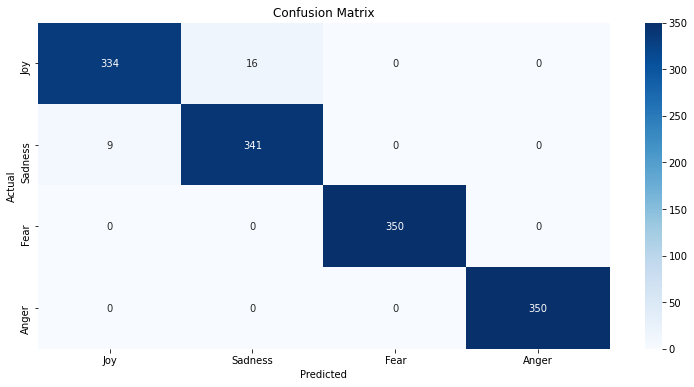

In [24]:
print("Classification report\n", classification_report(actual_classes, predicted_classes))
print(f"Accuracy: {accuracy_score(actual_classes, predicted_classes)}")
plot_confusion_matrix(actual_classes, predicted_classes, EMOTIONS)

In [25]:
model.fit(X_train, y_train)

tfidf_features = tfidf_vectorizer.transform(df_reviews_val['Review Text Wordcloud']).toarray()

X_val = pd.concat([df_reviews_val.iloc[:,[3,5]], pd.DataFrame(tfidf_features)], axis=1)
y_val = df_reviews_val['Emotion']

actual_classes = y_val
predicted_classes = model.predict(X_val)
predicted_proba = model.predict_proba(X_val)

In [26]:
save_object(model, f"{DATA_OUT_FOLDER}{MODEL_FILE}")
save_object(tfidf_vectorizer, f"{DATA_OUT_FOLDER}{VECTORIZER_FILE}")

Classification report
               precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         3
        Fear       0.00      0.00      0.00         2
         Joy       0.97      0.93      0.95       324
     Sadness       0.39      0.73      0.51        22

    accuracy                           0.90       351
   macro avg       0.34      0.41      0.36       351
weighted avg       0.92      0.90      0.91       351

Accuracy: 0.9031339031339032


C:\Users\GHarrison\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


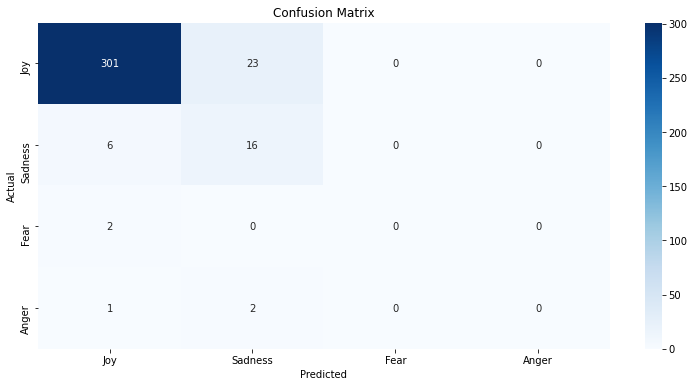

In [27]:
print("Classification report\n", classification_report(actual_classes, predicted_classes))
print(f"Accuracy: {accuracy_score(actual_classes, predicted_classes)}")
plot_confusion_matrix(actual_classes, predicted_classes, EMOTIONS)

TODO

1. Convert the predicted emotion codes back to textual emotions with a nice lambda function.
2. Append the predicted emotions and predicted probabilities into the clean data.
3. Take a look and see what the results look like.
4. Apply the results to all 23,000 rows (after removing the nulls).

Voila!!

In [28]:
ALPHABETICAL_EMOTION_MAP : dict = {
                                  'Anger': 0,
                                  'Fear': 1,
                                  'Joy': 2,
                                  'Sadness': 3
                                  }

first_index = np.arange(len(predicted_classes))
second_index = pd.Series(predicted_classes).map(ALPHABETICAL_EMOTION_MAP).to_numpy()
    
associated_proba = predicted_proba[first_index, second_index]

In [29]:
df_reviews_val["Predicted Emotion"] = predicted_classes
df_reviews_val["Predicted Emotion Score"] = associated_proba

In [30]:
df_reviews_val[['Emotion', 'Emotion Score', 'Predicted Emotion', 'Predicted Emotion Score']].head(50)

,Emotion,Emotion Score,Predicted Emotion,Predicted Emotion Score
0,Joy,0.796461,Joy,0.868333
1,Joy,0.702502,Joy,0.671066
2,Joy,0.855898,Joy,0.832500
3,Sadness,0.519885,Sadness,0.472960
4,Joy,0.664518,Joy,0.888750
5,Joy,0.615711,Joy,0.542575
6,Joy,0.615737,Joy,0.742984
7,Joy,0.686012,Joy,0.843750
8,Anger,0.541525,Sadness,0.612050
9,Joy,0.738641,Joy,0.856177


Now let's apply our new emotional tone analyzer to the full dataset ...

In [31]:
%%time
df_reviews_prod = pd.read_excel(f"{DATA_IN_FOLDER}{SOURCE_FULL_DATA_FILE}") # Read in the full source data file with 23k rows

model = load_object(f"{DATA_OUT_FOLDER}{MODEL_FILE}") # Load the machine learning model from persistent storage
tfidf_vectorizer = load_object(f"{DATA_OUT_FOLDER}{VECTORIZER_FILE}") # Load the word vectoriaing transformer from persistent storage

tfidf_features = tfidf_vectorizer.transform(df_reviews_prod['Review Text Wordcloud']).toarray() # Predict the vectorized words from the word cloud

X_prod = pd.concat([df_reviews_prod.iloc[:,[3,5]], pd.DataFrame(tfidf_features)], axis=1) # Create the input features to the model as source data features 3 and 5 and the vectorized features

predicted_classes = model.predict(X_prod) # Predict the classes (emotional tones) for the full dataset
predicted_proba = model.predict_proba(X_prod) # Predcit the probabilities (of membership of each of the four classes) for the full dataset

# Extract the associated probability of the predicted class from predicted_proba
first_index = np.arange(len(predicted_classes))
second_index = pd.Series(predicted_classes).map(ALPHABETICAL_EMOTION_MAP).to_numpy()
associated_proba = predicted_proba[first_index, second_index]

df_reviews_prod['Emotion'] = predicted_classes # Update the target data with the predicted emotions
df_reviews_prod['Emotion Score'] = associated_proba # Update the target data with the associated probabilities (emotion scores)

df_reviews_prod.to_excel(f"{DATA_OUT_FOLDER}{TARGET_FULL_DATA_FILE}", index=False, sheet_name="reviews") # Write the transformed data to a new Excel spreadsheet (preserving the original)

Wall time: 14 s


In [32]:
df_reviews_raw['Emotion'].value_counts(normalize=True, dropna=False)

Joy        0.7940
NaN        0.1235
Sadness    0.0685
Anger      0.0075
Fear       0.0065
Name: Emotion, dtype: float64

In [33]:
df_reviews_prod['Emotion'].value_counts(normalize=True, dropna=False)

Joy        0.863239
Sadness    0.135490
Anger      0.000712
Fear       0.000559
Name: Emotion, dtype: float64

https://towardsdatascience.com/dont-just-fit-data-gain-insights-too-1dba73d3cf8e

https://grahamharrison-86487.medium.com/membership